In [1]:
from glob import glob
import sys
import getpass
import os
# import psutil
from os.path import join, dirname
from os.path import getsize
import pickle
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.stats.multitest
# from statsmodels.sandbox.stats.multicomp import multipletests

# import nilearn.masking
from nilearn import plotting as nplt
from nilearn import image as niimg
import nilearn.decoding

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

# import mydef as my Class correction for projects
import mydef

/usr/local/anaconda3/envs/sampark/lib/python3.7/site-packages/nilearn/datasets/__init__.py:90: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
GA = mydef.GA()

Google Drive is detected!


# ROI list

## Movement-related ROIs from localizer

In [3]:
## ROI
path_list = sorted(glob(join(GA.dir_mask,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    GA.roi_imgs[roi] = niimg.load_img(path)
GA.roi_imgs

{'n200_c1-1_L_M1': <nibabel.nifti1.Nifti1Image at 0x7fea706dff10>,
 'n200_c1-2_L_S1': <nibabel.nifti1.Nifti1Image at 0x7fea81714450>,
 'n200_c1_L_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fea817145d0>,
 'n200_c1_R_SPL': <nibabel.nifti1.Nifti1Image at 0x7fea81714810>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7fea817149d0>,
 'n200_c2_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7fea81714c10>,
 'n200_c3_R_MTG': <nibabel.nifti1.Nifti1Image at 0x7fea81714e50>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fea81714f50>,
 'n200_c4_L_IFG': <nibabel.nifti1.Nifti1Image at 0x7fea81774250>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7fea81774450>,
 'n200_c5_L_SPL': <nibabel.nifti1.Nifti1Image at 0x7fea81774690>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7fea81774890>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7fea817749d0>,
 'n200_c6_R_MFG': <nibabel.nifti1.Nifti1Image at 0x7fea81774c90>,
 'n200_c7_L_Thalamus': <nibabel

In [4]:
key_list = ['n200_c1_L_Postcentral'
            , 'n200_c2_R_CerebellumIV-V'
            , 'n200_c3_R_Postcentral'
            , 'n200_c4_L_Putamen'
            , 'n200_c5_R_SMA'
            , 'n200_c6_R_CerebellumVIIIb'
            , 'n200_c7_L_Thalamus']
temp = {}
for key in key_list:
    temp[key] = GA.roi_imgs[key]
GA.roi_imgs = temp
GA.roi_imgs

{'n200_c1_L_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fea817145d0>,
 'n200_c2_R_CerebellumIV-V': <nibabel.nifti1.Nifti1Image at 0x7fea817149d0>,
 'n200_c3_R_Postcentral': <nibabel.nifti1.Nifti1Image at 0x7fea81714f50>,
 'n200_c4_L_Putamen': <nibabel.nifti1.Nifti1Image at 0x7fea81774450>,
 'n200_c5_R_SMA': <nibabel.nifti1.Nifti1Image at 0x7fea81774890>,
 'n200_c6_R_CerebellumVIIIb': <nibabel.nifti1.Nifti1Image at 0x7fea817749d0>,
 'n200_c7_L_Thalamus': <nibabel.nifti1.Nifti1Image at 0x7fea81774e50>}

### The Classification Accuracies of the above ROIs

### *Calculation
*run once

In [5]:
# for subj in GA.list_subj:
for subj in ['01', '02']:
    for stage in GA.list_stage:
        GA.cross_valid(GA.load_beta(subj, stage), GA.lda)

In [8]:
## save the result
GA.save_pkl(data=GA.scores, suffix='7localizers')

### Wit dataframe

In [5]:
## compare by type
GA.show_pkl_list(GA.dir_script, word='7localizers')

,name,identity
0,20210511_7localizers.pkl,a


In [6]:
## load scores
GA.scores = GA.load_pkl(fname='20210511_7localizers.pkl')

In [7]:
GA.make_wit_score()

,subj,ROI,visit,mapping,accuracy_1,accuracy_2,accuracy_3,mean_accuracy
0,01,n200_c1_L_Postcentral,early,practice,0.322917,0.427083,0.385417,0.378472
1,01,n200_c2_R_CerebellumIV-V,early,practice,0.239583,0.218750,0.322917,0.260417
2,01,n200_c3_R_Postcentral,early,practice,0.312500,0.291667,0.333333,0.312500
3,01,n200_c4_L_Putamen,early,practice,0.250000,0.322917,0.208333,0.260417
4,01,n200_c5_R_SMA,early,practice,0.333333,0.322917,0.354167,0.336806
...,...,...,...,...,...,...,...,...
835,44,n200_c3_R_Postcentral,late,unpractice,0.281250,0.322917,0.260417,0.288194
836,44,n200_c4_L_Putamen,late,unpractice,0.333333,0.322917,0.302083,0.319444
837,44,n200_c5_R_SMA,late,unpractice,0.312500,0.229167,0.208333,0.250000
838,44,n200_c6_R_CerebellumVIIIb,late,unpractice,0.343750,0.218750,0.270833,0.277778


n200_c1_L_Postcentral(n_voxles=200)
n200_c2_R_CerebellumIV-V(n_voxles=200)
n200_c3_R_Postcentral(n_voxles=200)
n200_c4_L_Putamen(n_voxles=200)
n200_c5_R_SMA(n_voxles=200)
n200_c6_R_CerebellumVIIIb(n_voxles=200)
n200_c7_L_Thalamus(n_voxles=200)


0

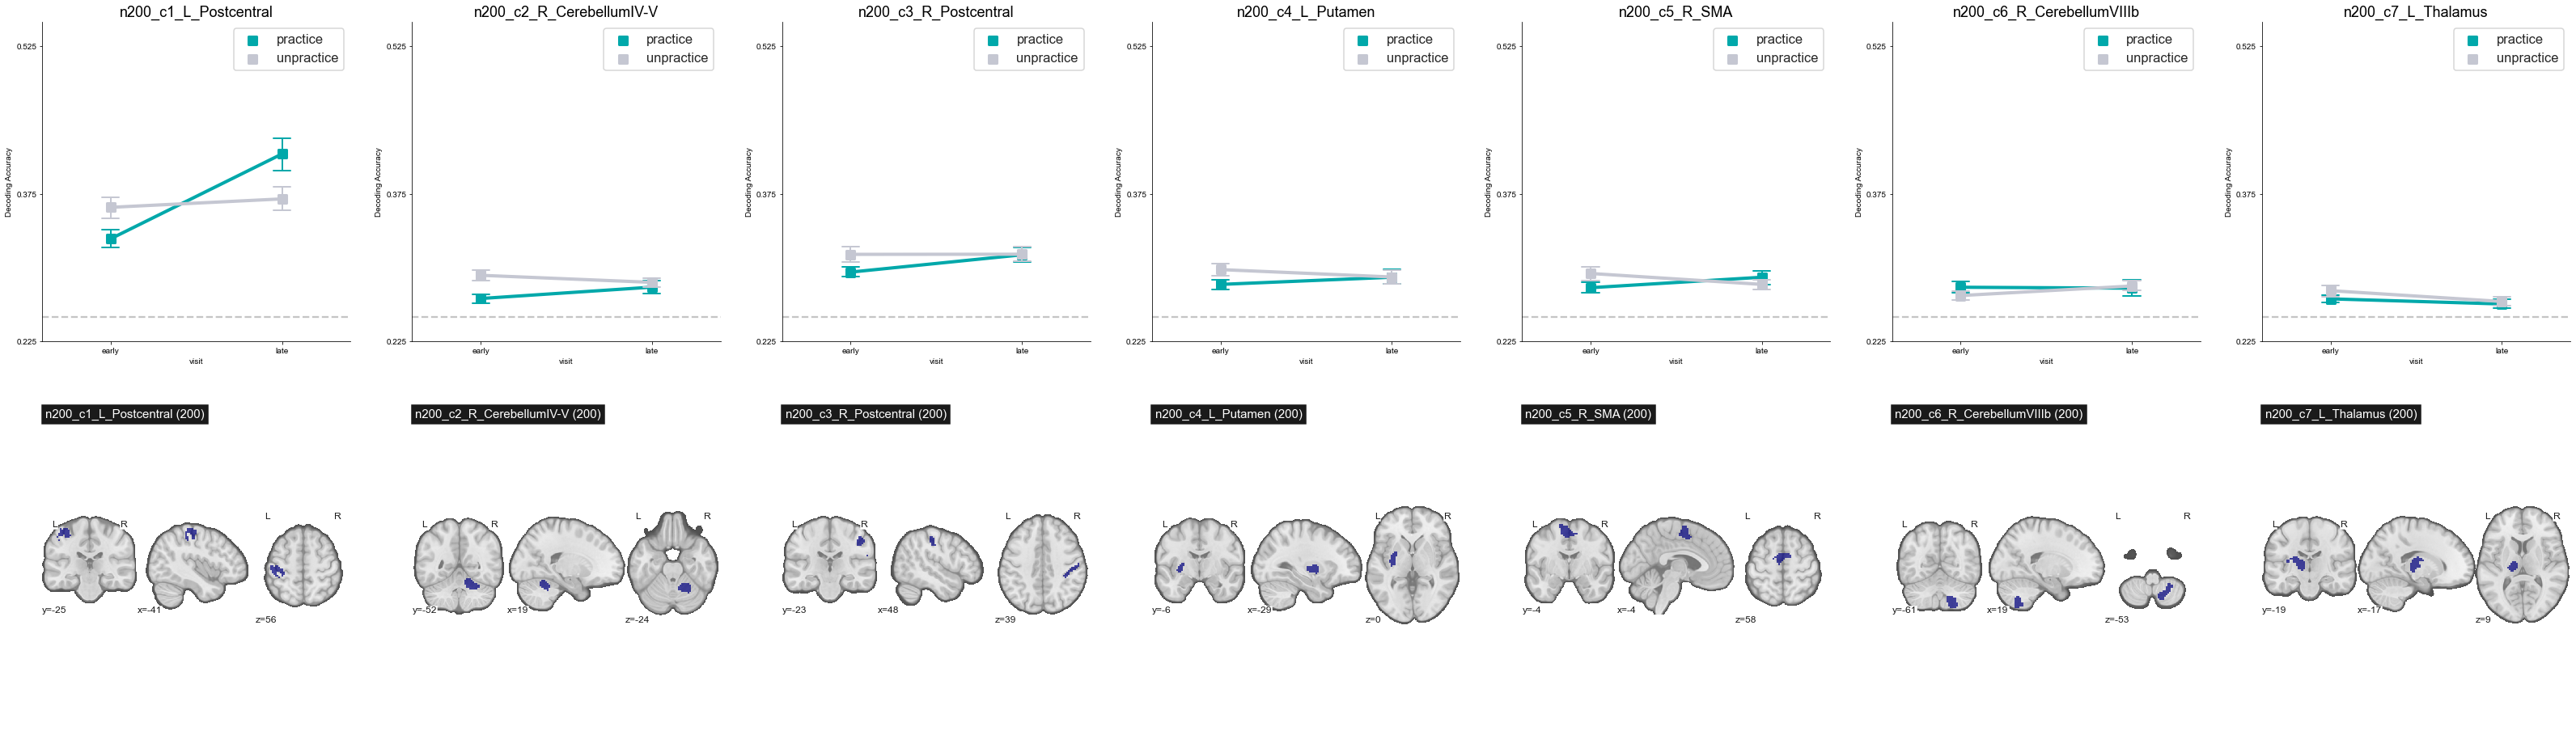

In [8]:
GA.draw_lineplots_with_rois(img_bg=GA.img_bg, n_columns=7)

In [9]:
GA.do_paired_ttest('early_practice','late_practice')

,ROI,cond_A,cond_B,t-statistic,Two-sided p-value,rejected,pvalue-corrected
0,n200_c1_L_Postcentral,early_practice,late_practice,-4.574044,0.000083,True,0.000083
1,n200_c2_R_CerebellumIV-V,early_practice,late_practice,-1.865849,0.072207,False,0.072207
2,n200_c3_R_Postcentral,early_practice,late_practice,-1.926143,0.063940,False,0.063940
3,n200_c4_L_Putamen,early_practice,late_practice,-0.863909,0.394728,False,0.394728
4,n200_c5_R_SMA,early_practice,late_practice,-1.338056,0.191276,False,0.191276
5,n200_c6_R_CerebellumVIIIb,early_practice,late_practice,0.097040,0.923362,False,0.923362
6,n200_c7_L_Thalamus,early_practice,late_practice,0.832935,0.411689,False,0.411689


In [10]:
GA.do_paired_ttest('early_practice','early_unpractice')

,ROI,cond_A,cond_B,t-statistic,Two-sided p-value,rejected,pvalue-corrected
0,n200_c1_L_Postcentral,early_practice,early_unpractice,-2.810440,0.008773,False,0.008773
1,n200_c2_R_CerebellumIV-V,early_practice,early_unpractice,-3.244826,0.002959,True,0.002959
2,n200_c3_R_Postcentral,early_practice,early_unpractice,-1.859598,0.073115,False,0.073115
3,n200_c4_L_Putamen,early_practice,early_unpractice,-1.900152,0.067397,False,0.067397
4,n200_c5_R_SMA,early_practice,early_unpractice,-1.781301,0.085341,False,0.085341
5,n200_c6_R_CerebellumVIIIb,early_practice,early_unpractice,1.298888,0.204216,False,0.204216
6,n200_c7_L_Thalamus,early_practice,early_unpractice,-1.218488,0.232859,False,0.232859


In [11]:
GA.do_paired_ttest('late_practice','late_unpractice')

,ROI,cond_A,cond_B,t-statistic,Two-sided p-value,rejected,pvalue-corrected
0,n200_c1_L_Postcentral,late_practice,late_unpractice,3.154366,0.003728,True,0.003728
1,n200_c2_R_CerebellumIV-V,late_practice,late_unpractice,-0.597574,0.554762,False,0.554762
2,n200_c3_R_Postcentral,late_practice,late_unpractice,-0.074177,0.941379,False,0.941379
3,n200_c4_L_Putamen,late_practice,late_unpractice,-0.033267,0.973689,False,0.973689
4,n200_c5_R_SMA,late_practice,late_unpractice,1.001306,0.324961,False,0.324961
5,n200_c6_R_CerebellumVIIIb,late_practice,late_unpractice,-0.232368,0.817884,False,0.817884
6,n200_c7_L_Thalamus,late_practice,late_unpractice,-0.402506,0.690263,False,0.690263


In [12]:
GA.make_wit_mean_ttest(stage='early_practice', mean=0.25)

,ROI,visit,mapping,tval,pval_uncorrected,reject,pval_corrected
0,n200_c1_L_Postcentral,early,practice,8.703611,1.394858e-09,True,1.394858e-09
1,n200_c2_R_CerebellumIV-V,early,practice,3.806147,6.754291e-04,True,6.754291e-04
2,n200_c3_R_Postcentral,early,practice,9.022293,6.455393e-10,True,6.455393e-10
3,n200_c4_L_Putamen,early,practice,6.371906,5.772277e-07,True,5.772277e-07
4,n200_c5_R_SMA,early,practice,5.639728,4.297449e-06,True,4.297449e-06
5,n200_c6_R_CerebellumVIIIb,early,practice,5.129903,1.767790e-05,True,1.767790e-05
6,n200_c7_L_Thalamus,early,practice,4.464133,1.121099e-04,True,1.121099e-04


## My replicated ROIs from localizers

In [18]:
## ROI
GA.roi_imgs = {}
path_list = sorted(glob(join(GA.dir_mask,'localizer_sampark','n*.nii.gz')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    GA.roi_imgs[roi] = niimg.load_img(path)
GA.roi_imgs

{'n200.L_Thalamus.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84646e7c10>,
 'n200.R_CerebellumVIIIb.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84646e7f40>,
 'n200.R_Postcentral.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84646e76a0>,
 'n201.L_Postcentral.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84646e7250>,
 'n202.R_CerebellumIV-V.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84646e7ac0>,
 'n202.S_SMA.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f8461e08df0>,
 'n225.L_Putamen.nii.gz': <nibabel.nifti1.Nifti1Image at 0x7f84538a24c0>}

n200.L_Thalamus.nii.gz(n_voxles=200)
n200.R_CerebellumVIIIb.nii.gz(n_voxles=200)
n200.R_Postcentral.nii.gz(n_voxles=200)
n201.L_Postcentral.nii.gz(n_voxles=201)
n202.R_CerebellumIV-V.nii.gz(n_voxles=202)
n202.S_SMA.nii.gz(n_voxles=202)
n225.L_Putamen.nii.gz(n_voxles=225)


0

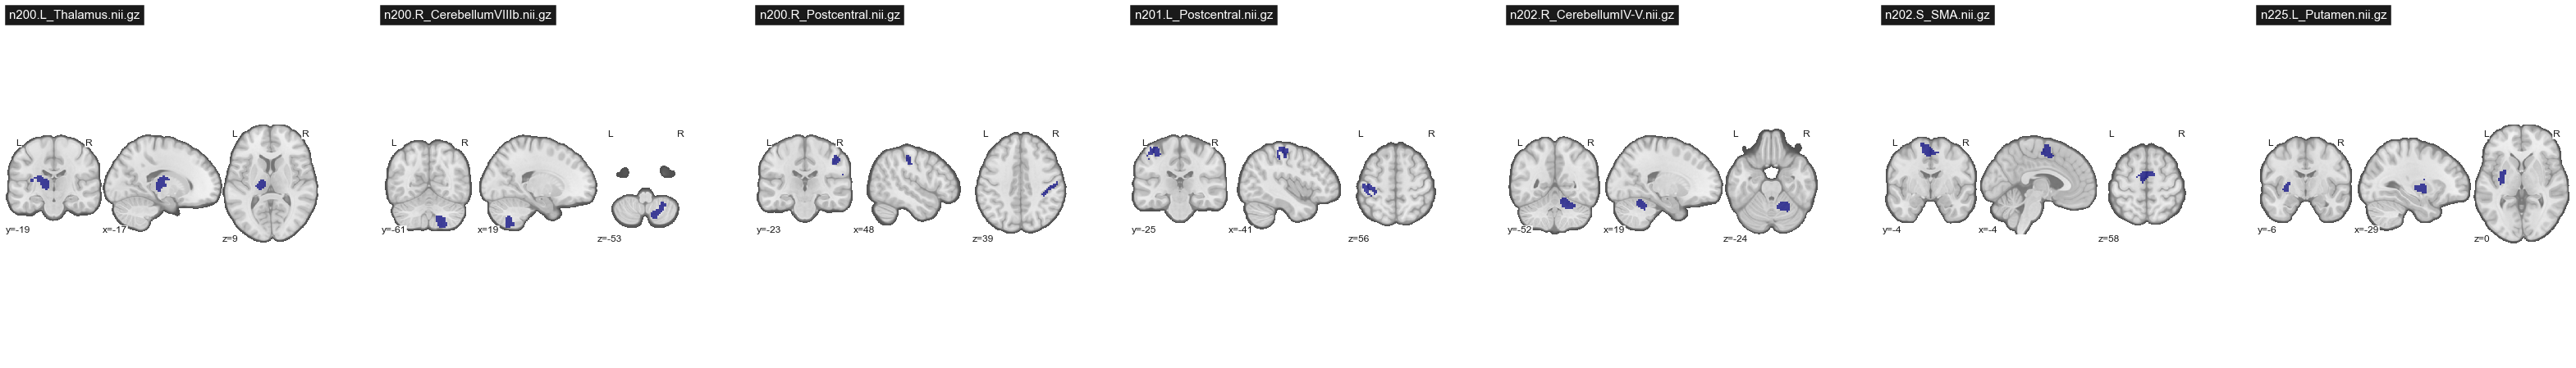

In [19]:
GA.draw_rois(img_bg=img_bg, n_columns=7)

## Default Mode Network

In [14]:
GA.__init__()

Google Drive is detected!


In [16]:
## DMN regions(global)
module_names = ['Core', 'dMsub', 'MTLsub']

for name in module_names:
    DMN_list = glob(join(GA.dir_dmn, name+'.nii'))
    for path in DMN_list:
        fname = path.split('/')[-1].replace('.nii', '')
        GA.roi_imgs[fname] = nilearn.image.load_img(path)
        
# ## DMN regions(detail)
module_names = ['Core', 'dMsub', 'MTLsub']

for name in module_names:
    DMN_list = glob(join(GA.dir_dmn, name+'_*.nii'))
    for path in DMN_list:
        fname = path.split('/')[-1].replace('.nii', '')
        GA.roi_imgs[fname] = nilearn.image.load_img(path)

GA.roi_imgs

{'Core': <nibabel.nifti1.Nifti1Image at 0x7fea7a425ed0>,
 'dMsub': <nibabel.nifti1.Nifti1Image at 0x7fea7a425210>,
 'MTLsub': <nibabel.nifti1.Nifti1Image at 0x7fea7a43b090>,
 'Core_PCC_r': <nibabel.nifti1.Nifti1Image at 0x7fea7a43b110>,
 'Core_aMPFC_l': <nibabel.nifti1.Nifti1Image at 0x7fea7a43b650>,
 'Core_PCC_l': <nibabel.nifti1.Nifti1Image at 0x7fea7a43b8d0>,
 'Core_aMPFC_r': <nibabel.nifti1.Nifti1Image at 0x7fea7a43bad0>,
 'dMsub_TempP_r_temp': <nibabel.nifti1.Nifti1Image at 0x7fea7a43b910>,
 'dMsub_dMPFC': <nibabel.nifti1.Nifti1Image at 0x7fea7a43bd50>,
 'dMsub_TempP_l_temp': <nibabel.nifti1.Nifti1Image at 0x7fea7a43b190>,
 'dMsub_TPJ_l': <nibabel.nifti1.Nifti1Image at 0x7fea72acdc10>,
 'dMsub_LTC_l': <nibabel.nifti1.Nifti1Image at 0x7fea72acdf90>,
 'dMsub_TPJ_r': <nibabel.nifti1.Nifti1Image at 0x7fea72ab60d0>,
 'dMsub_LTC_r': <nibabel.nifti1.Nifti1Image at 0x7fea93182050>,
 'MTLsub_HF_r': <nibabel.nifti1.Nifti1Image at 0x7fea931822d0>,
 'MTLsub_PHC_r': <nibabel.nifti1.Nifti1Image

### Check that the default ROIs are equal to the sum of their sub-ROIs.

In [22]:
# ## Core
# img_sum = nilearn.image.math_img(
#     formula="img1+img2+img3+img4 > 0",
#     img1=GA.roi_imgs['Core_PCC_l'], img2=GA.roi_imgs['Core_PCC_r'], img3=GA.roi_imgs['Core_aMPFC_l'], img4=GA.roi_imgs['Core_aMPFC_r']
# )
# img_res = nilearn.image.math_img(formula="img1-img2", img1=GA.roi_imgs['Core'], img2=img_sum)
# img_res.get_fdata().sum()

0.0

In [23]:
# ## MTL
# img_sum = nilearn.image.math_img(
#     formula="img1+img2+img3+img4+img5+img6+img7+img8+img9 > 0",
#     img1=GA.roi_imgs['MTLsub_HF_l'], img2=GA.roi_imgs['MTLsub_HF_r']
#     , img3=GA.roi_imgs['MTLsub_PHC_l'], img4=GA.roi_imgs['MTLsub_PHC_r']
#     , img5=GA.roi_imgs['MTLsub_Rsp_l'], img6=GA.roi_imgs['MTLsub_Rsp_r']
#     , img7=GA.roi_imgs['MTLsub_pIPL_l'], img8=GA.roi_imgs['MTLsub_pIPL_r']
#     , img9=GA.roi_imgs['MTLsub_vMPFC']
# )
# img_res = nilearn.image.math_img(formula="img1-img2", img1=GA.roi_imgs['MTLsub'], img2=img_sum)
# img_res.get_fdata().sum()

0.0

In [25]:
# ## DMPFC
# img_sum = nilearn.image.math_img(
#     formula="img1+img2+img3+img4+img5+img6+img7 > 0",
#     img1=GA.roi_imgs['dMsub_LTC_l'], img2=GA.roi_imgs['dMsub_LTC_r']
#     , img3=GA.roi_imgs['dMsub_TPJ_l'], img4=GA.roi_imgs['dMsub_TPJ_r']
#     , img5=GA.roi_imgs['dMsub_TempP_l_temp'], img6=GA.roi_imgs['dMsub_TempP_r_temp']
#     , img7=GA.roi_imgs['dMsub_dMPFC']
# )
# img_res = nilearn.image.math_img(formula="img1-img2", img1=GA.roi_imgs['dMsub'], img2=img_sum)
# img_res.get_fdata().sum()

0.0

### The Classification Accuracies of the above ROIs

### *Calculation
*run once

In [4]:
for subj in GA.list_subj:
    for stage in GA.list_stage:
        GA.cross_valid(GA.load_beta(subj, stage), GA.lda)

In [5]:
## save the result
GA.save_pkl(data=GA.scores, suffix='DMN')

### Wit dataframe

In [17]:
## compare the results by type
GA.show_pkl_list(GA.dir_script, 'DMN')

,name,identity
0,20210511_DMN.pkl,a
1,20210511_Yeo1-DMN.pkl,b


In [18]:
## load scores
GA.scores = GA.load_pkl(fname='20210511_DMN.pkl')

In [19]:
GA.make_wit_score()

,subj,ROI,visit,mapping,accuracy_1,accuracy_2,accuracy_3,mean_accuracy
0,01,Core,early,practice,0.447917,0.333333,0.270833,0.350694
1,01,dMsub,early,practice,0.354167,0.260417,0.385417,0.333333
2,01,MTLsub,early,practice,0.406250,0.333333,0.302083,0.347222
3,01,Core_PCC_r,early,practice,0.364583,0.458333,0.291667,0.371528
4,01,Core_aMPFC_l,early,practice,0.354167,0.281250,0.312500,0.315972
...,...,...,...,...,...,...,...,...
2755,44,MTLsub_vMPFC,late,unpractice,0.343750,0.291667,0.281250,0.305556
2756,44,MTLsub_pIPL_l,late,unpractice,0.270833,0.250000,0.354167,0.291667
2757,44,MTLsub_HF_l,late,unpractice,0.291667,0.291667,0.302083,0.295139
2758,44,MTLsub_PHC_l,late,unpractice,0.322917,0.291667,0.281250,0.298611


Core(n_voxles=760)
dMsub(n_voxles=1166)
MTLsub(n_voxles=1766)
Core_PCC_r(n_voxles=203)
Core_aMPFC_l(n_voxles=203)
Core_PCC_l(n_voxles=203)
Core_aMPFC_r(n_voxles=203)
dMsub_TempP_r_temp(n_voxles=90)
dMsub_dMPFC(n_voxles=203)
dMsub_TempP_l_temp(n_voxles=79)
dMsub_TPJ_l(n_voxles=203)
dMsub_LTC_l(n_voxles=196)
dMsub_TPJ_r(n_voxles=202)
dMsub_LTC_r(n_voxles=193)
MTLsub_HF_r(n_voxles=203)
MTLsub_PHC_r(n_voxles=203)
MTLsub_Rsp_r(n_voxles=203)
MTLsub_pIPL_r(n_voxles=170)
MTLsub_vMPFC(n_voxles=191)
MTLsub_pIPL_l(n_voxles=187)
MTLsub_HF_l(n_voxles=203)
MTLsub_PHC_l(n_voxles=203)
MTLsub_Rsp_l(n_voxles=203)


0

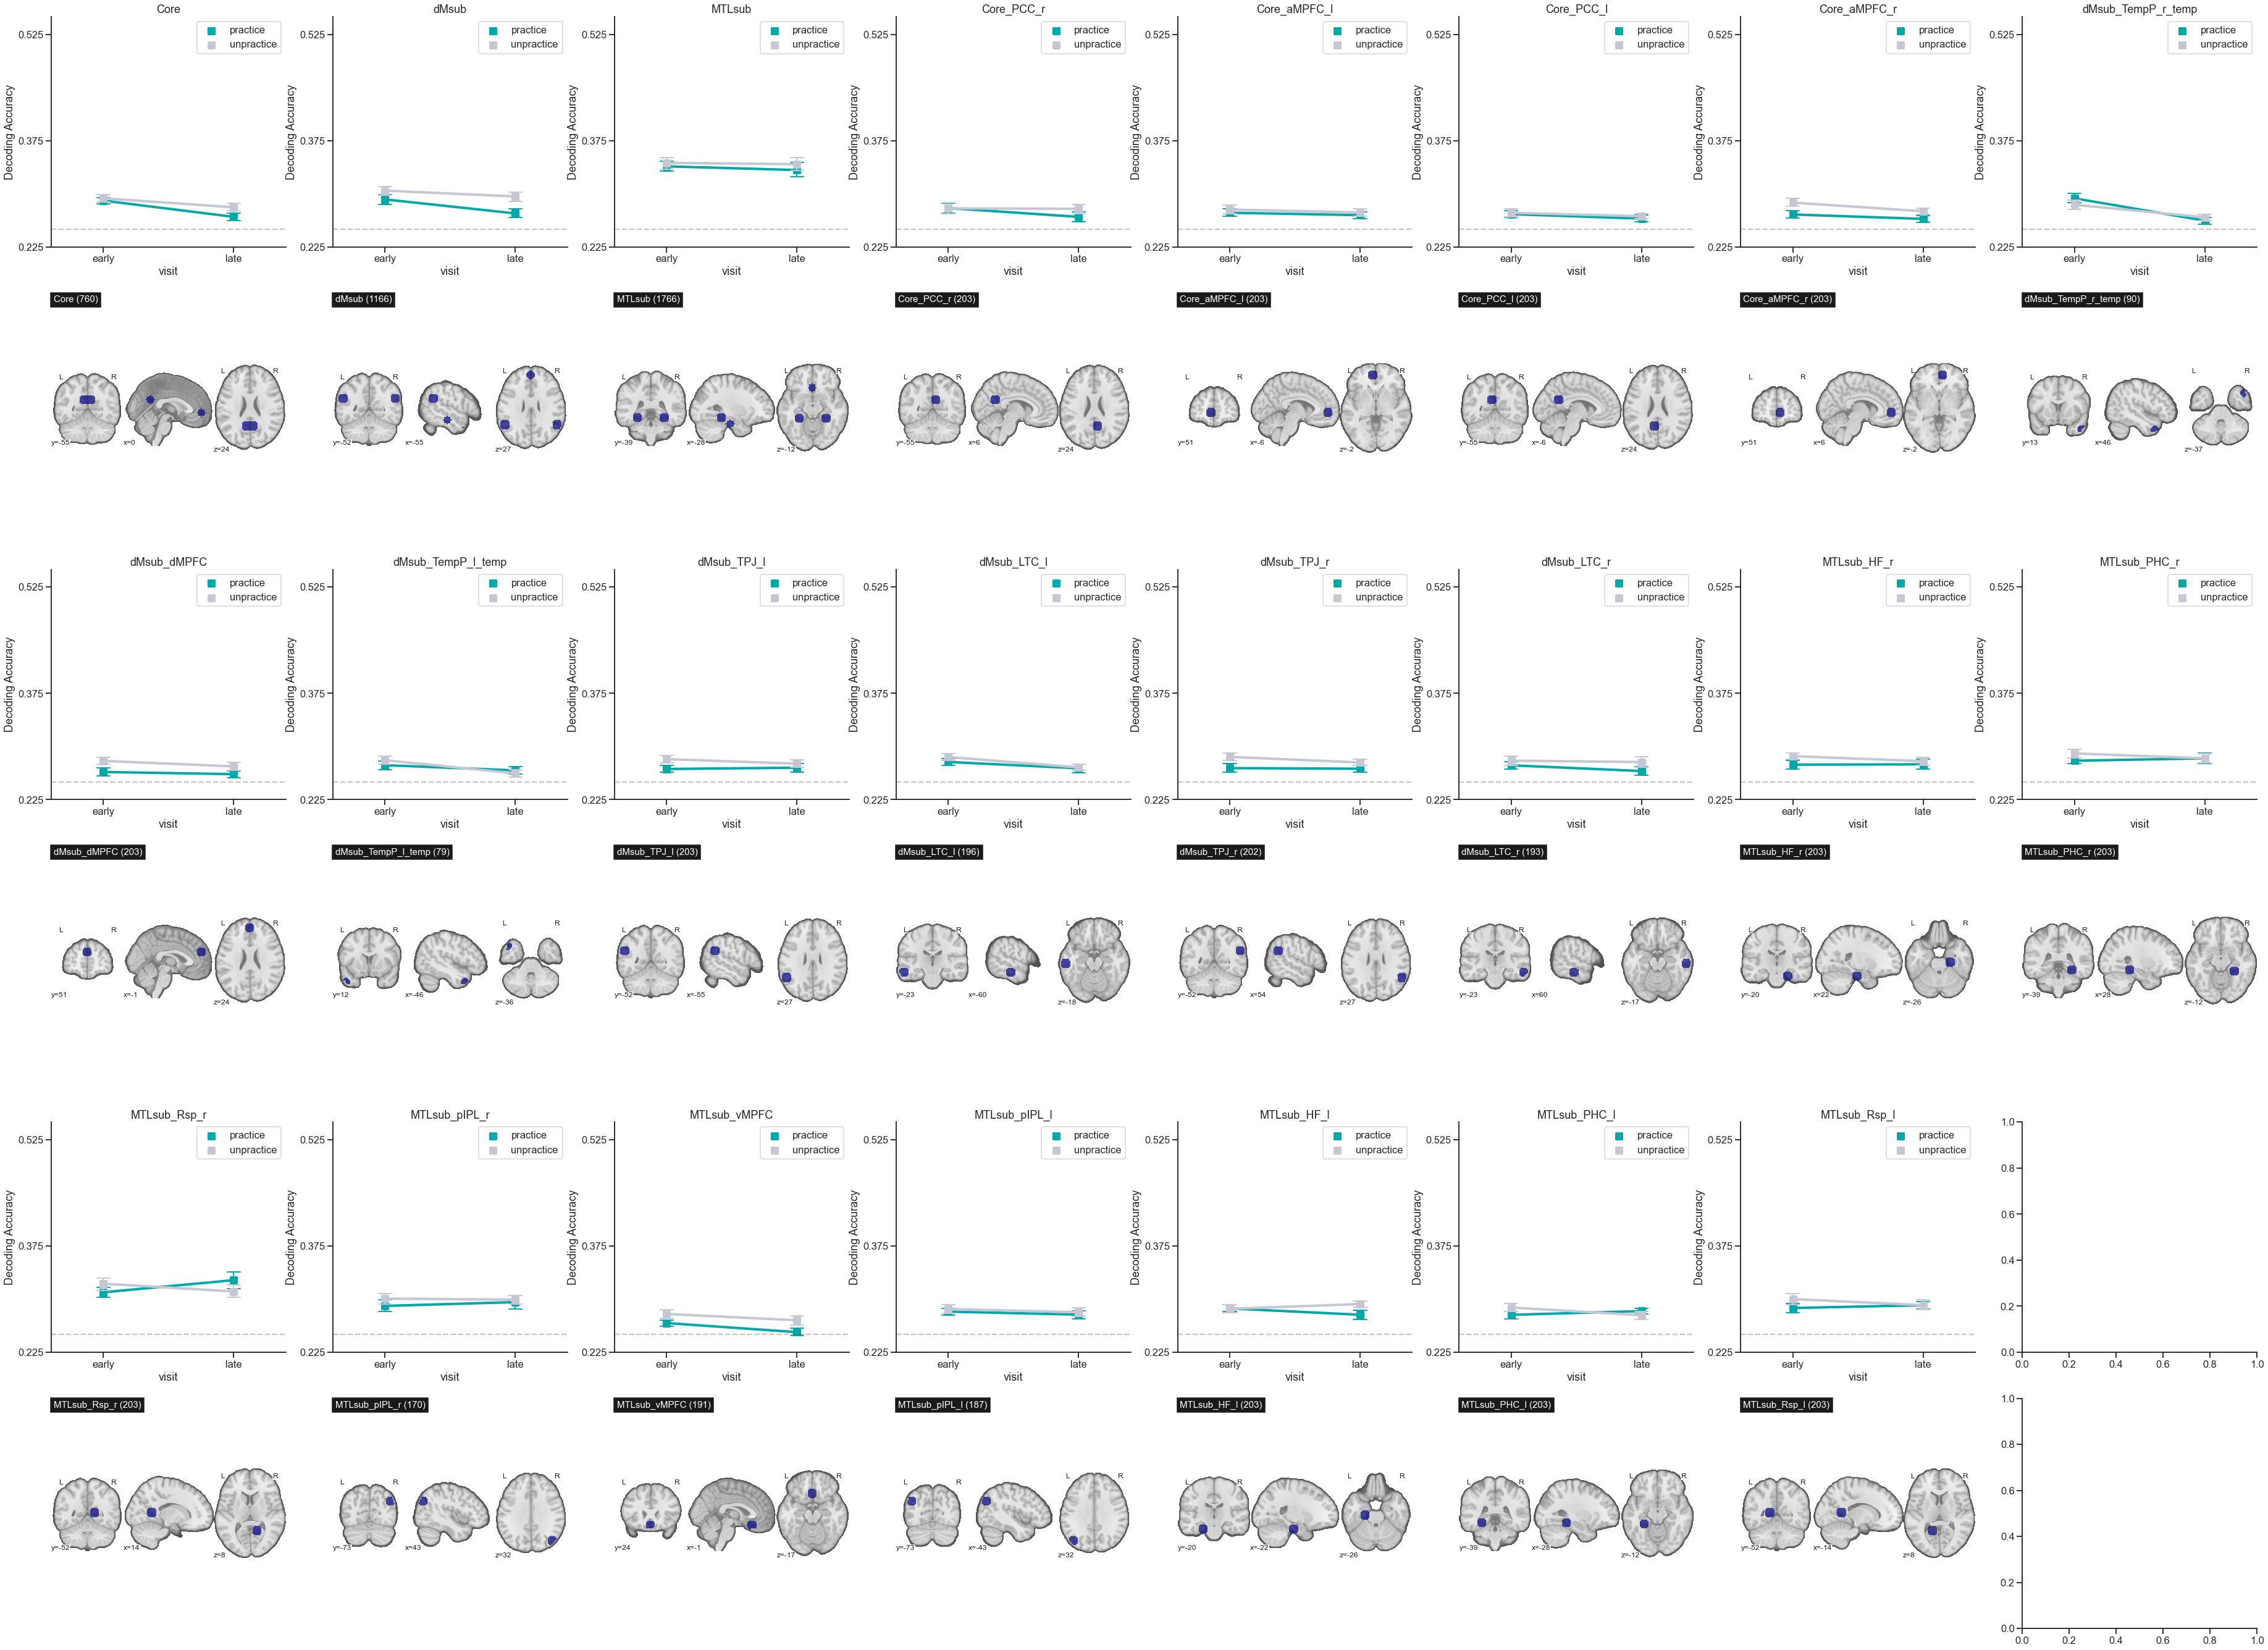

In [20]:
GA.draw_lineplots_with_rois(img_bg=GA.img_bg, n_columns=8)

In [21]:
GA.make_wit_mean_ttest(stage='early_practice', mean=0.25)

,ROI,visit,mapping,tval,pval_uncorrected,reject,pval_corrected
0,Core,early,practice,9.557470,1.824209e-10,True,1.824209e-10
1,dMsub,early,practice,5.784743,2.879420e-06,True,2.879420e-06
2,MTLsub,early,practice,12.597609,2.757169e-13,True,2.757169e-13
3,Core_PCC_r,early,practice,4.341874,1.570437e-04,True,1.570437e-04
4,Core_aMPFC_l,early,practice,4.303960,1.743049e-04,True,1.743049e-04
5,Core_PCC_l,early,practice,4.362740,1.482769e-04,True,1.482769e-04
6,Core_aMPFC_r,early,practice,3.927922,4.863837e-04,True,4.863837e-04
7,dMsub_TempP_r_temp,early,practice,6.640872,2.791293e-07,True,2.791293e-07
8,dMsub_dMPFC,early,practice,2.639808,1.321310e-02,False,1.321310e-02
9,dMsub_TempP_l_temp,early,practice,3.729146,8.302560e-04,True,8.302560e-04


In [22]:
GA.make_wit_mean_ttest(stage='late_practice', mean=0.25)

,ROI,visit,mapping,tval,pval_uncorrected,reject,pval_corrected
0,Core,late,practice,3.259191,2.851428e-03,True,2.851428e-03
1,dMsub,late,practice,3.605832,1.152894e-03,True,1.152894e-03
2,MTLsub,late,practice,7.334242,4.439901e-08,True,4.439901e-08
3,Core_PCC_r,late,practice,2.409334,2.255634e-02,False,2.255634e-02
4,Core_aMPFC_l,late,practice,4.343465,1.563576e-04,True,1.563576e-04
5,Core_PCC_l,late,practice,3.032346,5.071951e-03,False,5.071951e-03
6,Core_aMPFC_r,late,practice,2.814923,8.677852e-03,False,8.677852e-03
7,dMsub_TempP_r_temp,late,practice,2.624293,1.370684e-02,False,1.370684e-02
8,dMsub_dMPFC,late,practice,2.200810,3.586352e-02,False,3.586352e-02
9,dMsub_TempP_l_temp,late,practice,3.014728,5.300587e-03,False,5.300587e-03


In [23]:
GA.make_wit_mean_ttest(stage='early_unpractice', mean=0.25)

,ROI,visit,mapping,tval,pval_uncorrected,reject,pval_corrected
0,Core,early,unpractice,7.740036,1.553432e-08,True,1.553432e-08
1,dMsub,early,unpractice,8.474080,2.449785e-09,True,2.449785e-09
2,MTLsub,early,unpractice,10.933011,8.399663e-12,True,8.399663e-12
3,Core_PCC_r,early,unpractice,3.691938,9.169841e-04,True,9.169841e-04
4,Core_aMPFC_l,early,unpractice,4.261510,1.958627e-04,True,1.958627e-04
5,Core_PCC_l,early,unpractice,3.924405,4.910333e-04,True,4.910333e-04
6,Core_aMPFC_r,early,unpractice,6.662575,2.633160e-07,True,2.633160e-07
7,dMsub_TempP_r_temp,early,unpractice,5.592703,4.894442e-06,True,4.894442e-06
8,dMsub_dMPFC,early,unpractice,6.178657,9.767903e-07,True,9.767903e-07
9,dMsub_TempP_l_temp,early,unpractice,5.463812,6.994452e-06,True,6.994452e-06


In [24]:
GA.make_wit_mean_ttest(stage='late_unpractice', mean=0.25)

,ROI,visit,mapping,tval,pval_uncorrected,reject,pval_corrected
0,Core,late,unpractice,5.967202,1.742827e-06,True,1.742827e-06
1,dMsub,late,unpractice,7.205886,6.214671e-08,True,6.214671e-08
2,MTLsub,late,unpractice,9.895958,8.362789e-11,True,8.362789e-11
3,Core_PCC_r,late,unpractice,4.383198,1.401521e-04,True,1.401521e-04
4,Core_aMPFC_l,late,unpractice,4.046538,3.525206e-04,True,3.525206e-04
5,Core_PCC_l,late,unpractice,5.210050,1.414794e-05,True,1.414794e-05
6,Core_aMPFC_r,late,unpractice,5.957458,1.790087e-06,True,1.790087e-06
7,dMsub_TempP_r_temp,late,unpractice,3.567017,1.277622e-03,True,1.277622e-03
8,dMsub_dMPFC,late,unpractice,3.947171,4.616900e-04,True,4.616900e-04
9,dMsub_TempP_l_temp,late,unpractice,2.222099,3.423734e-02,False,3.423734e-02


In [25]:
GA.do_paired_ttest('early_practice','late_practice')

,ROI,cond_A,cond_B,t-statistic,Two-sided p-value,rejected,pvalue-corrected
0,Core,early_practice,late_practice,3.047261,0.004886,True,0.004886
1,dMsub,early_practice,late_practice,2.139986,0.040898,False,0.040898
2,MTLsub,early_practice,late_practice,0.412475,0.683024,False,0.683024
3,Core_PCC_r,early_practice,late_practice,1.304728,0.202245,False,0.202245
4,Core_aMPFC_l,early_practice,late_practice,0.494325,0.624801,False,0.624801
5,Core_PCC_l,early_practice,late_practice,0.887490,0.382117,False,0.382117
6,Core_aMPFC_r,early_practice,late_practice,0.985765,0.332402,False,0.332402
7,dMsub_TempP_r_temp,early_practice,late_practice,4.239094,0.000208,True,0.000208
8,dMsub_dMPFC,early_practice,late_practice,0.528320,0.601297,False,0.601297
9,dMsub_TempP_l_temp,early_practice,late_practice,0.882722,0.384646,False,0.384646


## Ventral visual stream (TT_Daemon, Brodmann Area)

In [26]:
GA.__init__()

Google Drive is detected!


In [27]:
path_list = glob(join(GA.dir_mask, 'TT_Daemon', '*.brik1.BA???.*.nii.gz'))
for path in path_list:
    temp = path.split('/')[-1].replace('.nii.gz', '')
    fname = temp.split('.')[2]
    GA.roi_imgs[fname] = nilearn.image.load_img(path)
GA.roi_imgs

{'BA19L': <nibabel.nifti1.Nifti1Image at 0x7fea85218f50>,
 'BA37R': <nibabel.nifti1.Nifti1Image at 0x7fea74a361d0>,
 'BA18L': <nibabel.nifti1.Nifti1Image at 0x7fea74a36590>,
 'BA17R': <nibabel.nifti1.Nifti1Image at 0x7fea74a36c10>,
 'BA19R': <nibabel.nifti1.Nifti1Image at 0x7fea8520f050>,
 'BA18R': <nibabel.nifti1.Nifti1Image at 0x7fea8520f390>,
 'BA38L': <nibabel.nifti1.Nifti1Image at 0x7fea8520f610>,
 'BA38R': <nibabel.nifti1.Nifti1Image at 0x7fea8520f890>,
 'BA20L': <nibabel.nifti1.Nifti1Image at 0x7fea8520fb10>,
 'BA17L': <nibabel.nifti1.Nifti1Image at 0x7fea8520fd10>,
 'BA20R': <nibabel.nifti1.Nifti1Image at 0x7fea74a2a1d0>,
 'BA37L': <nibabel.nifti1.Nifti1Image at 0x7fea74a2a290>}

## Fan280

In [3]:
GA.__init__()
GA.load_fan()

Google Drive is detected!


In [4]:
## DMN regions
module_names = ['Core']

for name in module_names:
    temp = glob(join(GA.dir_dmn, name+'_*.nii'))
    for path in temp:
        fname = path.split('/')[-1].replace('.nii', '')
        GA.roi_imgs[fname] = nilearn.image.load_img(path)

## yeo_17network == 1
dt = pd.DataFrame()
for nn in [1]:
    dt = dt.append(GA.fan_info[(GA.fan_info.yeo_17network == nn)])
for idx in dt.index:
    nn = dt.loc[idx,'label']
    region = dt.loc[idx,'region']
    GA.roi_imgs[region] = GA.fan_imgs[str(nn)]

In [6]:
## merging regions

### DMN
# GA.roi_imgs['Core'] = GA.merge_fan_rois()

### yeo_17network == 1
# GA.roi_imgs['yeo_17network_1'] = GA.merge_fan_rois(Yeo_Network=[1])

### yeo_17network == 2
# GA.roi_imgs['yeo_17network_2'] = merge_fan_rois(Yeo_Network=[2])

### yeo_17network == 1 or 2
# GA.roi_imgs['yeo_17network_1+2'] = merge_fan_rois(Yeo_Network=[1,2])

### subregion_name == 'V5/MT+'
# GA.roi_imgs['V5/MT'] = merge_fan_rois(Sub_Region=['V5/MT+'])

### *Calculation
*run once

In [7]:
for subj in GA.list_subj:
    for stage in GA.list_stage:
        GA.cross_valid(GA.load_beta(subj, stage), GA.lda)

In [10]:
## save the result
GA.save_pkl(data=GA.scores, suffix='Yeo1s-DMNs')

### Wit dataframe

In [11]:
## compare the results by type
GA.show_pkl_list(GA.dir_script, 'Yeo1')

,name,identity
0,20210525_Yeo1s-DMNs.pkl,a
1,20210517_func_correl.Core-Yeo1.pkl,b
2,20210511_Yeo1-DMN.pkl,c


In [13]:
## load scores
GA.scores = GA.load_pkl(fname='20210525_Yeo1s-DMNs.pkl')

In [14]:
GA.make_wit_score()

,subj,ROI,visit,mapping,accuracy_1,accuracy_2,accuracy_3,mean_accuracy
0,01,Core_PCC_r,early,practice,0.364583,0.458333,0.291667,0.371528
1,01,Core_aMPFC_l,early,practice,0.354167,0.281250,0.312500,0.315972
2,01,Core_PCC_l,early,practice,0.312500,0.333333,0.291667,0.312500
3,01,Core_aMPFC_r,early,practice,0.333333,0.312500,0.312500,0.319444
4,01,FuG_L_3_2,early,practice,0.510417,0.500000,0.572917,0.527778
...,...,...,...,...,...,...,...,...
2155,44,LOcC_L_4_3,late,unpractice,0.614583,0.552083,0.406250,0.524306
2156,44,LOcC_R_4_3,late,unpractice,0.718750,0.687500,0.343750,0.583333
2157,44,LOcC_L_4_4,late,unpractice,0.635417,0.645833,0.354167,0.545139
2158,44,LOcC_R_4_4,late,unpractice,0.583333,0.677083,0.333333,0.531250


Core_PCC_r(n_voxles=203)
Core_aMPFC_l(n_voxles=203)
Core_PCC_l(n_voxles=203)
Core_aMPFC_r(n_voxles=203)
FuG_L_3_2(n_voxles=348)
FuG_R_3_2(n_voxles=317)
MVOcC_L_5_1(n_voxles=207)
MVOcC_R_5_1(n_voxles=247)
MVOcC_L_5_3(n_voxles=259)
MVOcC_R_5_3(n_voxles=222)
MVOcC_R_5_4(n_voxles=366)
LOcC_L_4_1(n_voxles=334)
LOcC_R_4_1(n_voxles=336)
LOcC_L_4_3(n_voxles=396)
LOcC_R_4_3(n_voxles=422)
LOcC_L_4_4(n_voxles=460)
LOcC_R_4_4(n_voxles=383)
LOcC_L_2_2(n_voxles=238)


0

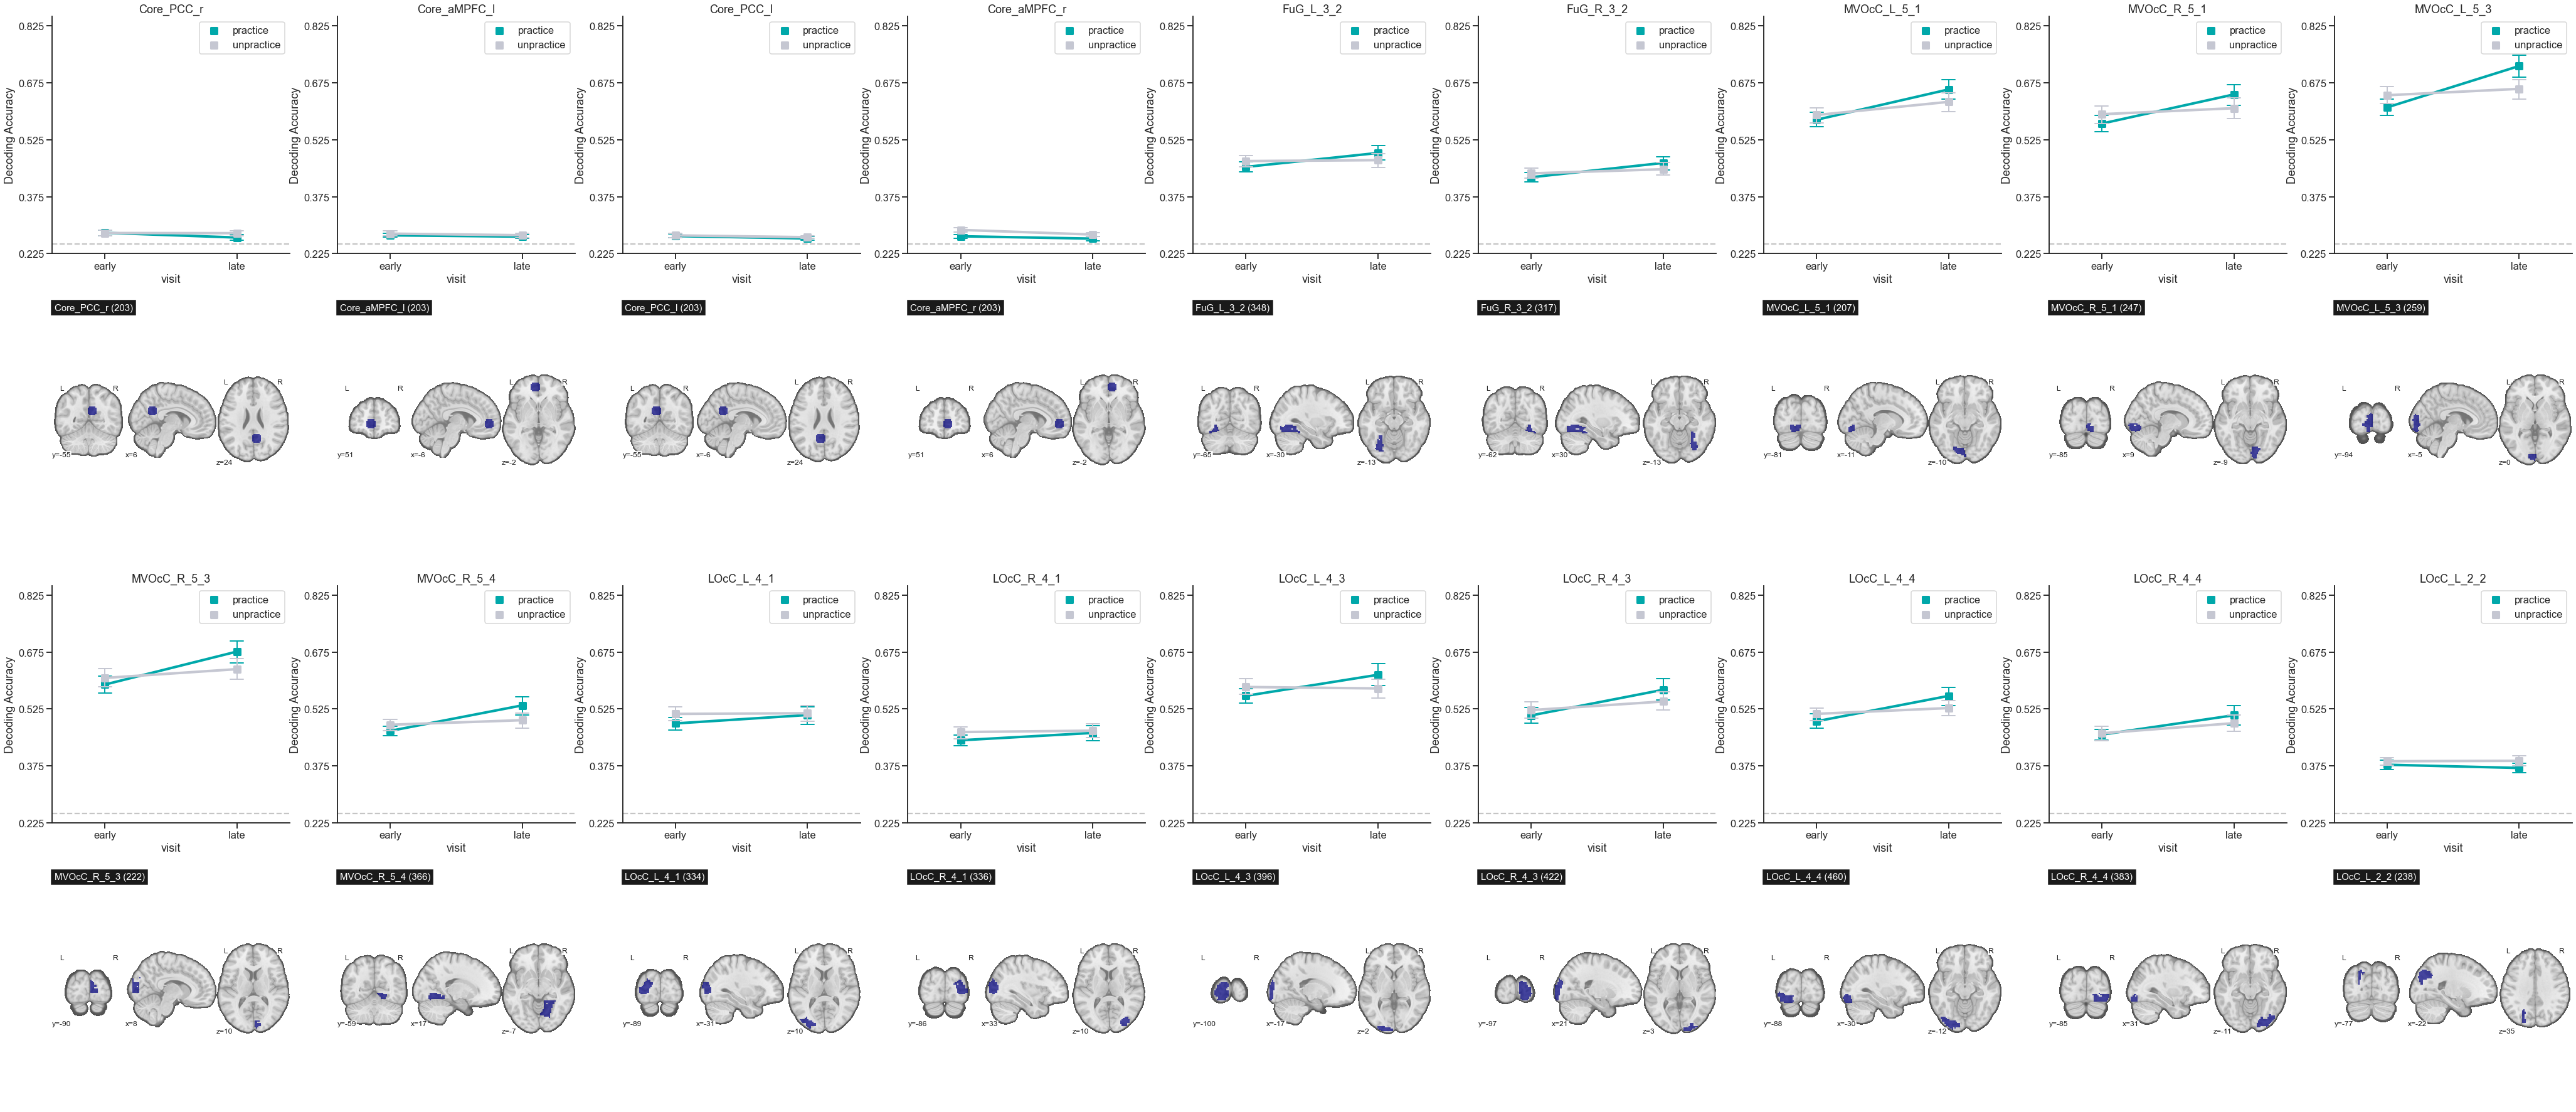

In [16]:
GA.draw_lineplots_with_rois(img_bg=GA.img_bg, n_columns=9, ylim=[.225, .85])

In [ ]:
GA.draw_lineplot_with_roi(roi_name='Core', img_bg=GA.img_bg, ylim=[.25,.30], dy=.025)
GA.draw_lineplot_with_roi(roi_name='yeo_17network_1', img_bg=GA.img_bg, ylim=[.25,.85], dy=.15)

## Correlation

In [3]:
GA.__init__()
GA.load_fan()

Google Drive is detected!


In [4]:
## DMN regions
module_names = ['Core']

for name in module_names:
    temp = glob(join(GA.dir_dmn, name+'_*.nii'))
    for path in temp:
        fname = path.split('/')[-1].replace('.nii', '')
        GA.roi_imgs[fname] = nilearn.image.load_img(path)

## yeo_17network == 1
dt = pd.DataFrame()
for nn in [1]:
    dt = dt.append(GA.fan_info[(GA.fan_info.yeo_17network == nn)])
for idx in dt.index:
    nn = dt.loc[idx,'label']
    region = dt.loc[idx,'region']
    GA.roi_imgs[region] = GA.fan_imgs[str(nn)]

In [65]:
GA.roi_imgs.keys()

dict_keys(['Core_PCC_r', 'Core_aMPFC_l', 'Core_PCC_l', 'Core_aMPFC_r', 'FuG_L_3_2', 'FuG_R_3_2', 'MVOcC_L_5_1', 'MVOcC_R_5_1', 'MVOcC_L_5_3', 'MVOcC_R_5_3', 'MVOcC_R_5_4', 'LOcC_L_4_1', 'LOcC_R_4_1', 'LOcC_L_4_3', 'LOcC_R_4_3', 'LOcC_L_4_4', 'LOcC_R_4_4', 'LOcC_L_2_2'])

### *calculate task-related networks (run once)

In [5]:
GA.make_wit_functional_correl()

,subj,visit,mapping,run,roiA,roiB,Pearson_r,pval
0,01,early,practice,r01,Core_PCC_l,Core_PCC_r,0.734662,1.529562e-186
1,01,early,practice,r01,Core_PCC_l,Core_aMPFC_l,0.490213,2.506783e-67
2,01,early,practice,r01,Core_PCC_l,Core_aMPFC_r,0.435352,6.615536e-52
3,01,early,practice,r01,Core_PCC_l,FuG_L_3_2,0.369261,9.733841e-37
4,01,early,practice,r01,Core_PCC_l,FuG_R_3_2,0.443622,4.700934e-54
...,...,...,...,...,...,...,...,...
55075,44,late,unpractice,r06,MVOcC_L_5_3,MVOcC_R_5_3,0.567933,1.311648e-94
55076,44,late,unpractice,r06,MVOcC_L_5_3,MVOcC_R_5_4,0.491638,9.117740e-68
55077,44,late,unpractice,r06,MVOcC_R_5_1,MVOcC_R_5_3,0.807197,1.032721e-252
55078,44,late,unpractice,r06,MVOcC_R_5_1,MVOcC_R_5_4,0.678643,8.405817e-149


In [6]:
GA.save_pkl(data=GA.wit_functional_correl, suffix='errts_correl.Yeo1s-Cores')

### load the result

In [3]:
GA.show_pkl_list(location=GA.dir_script, word='correl')

,name,identity
0,20210517_func_correl.Core-Yeo1.pkl,a
1,20210531_errts_correl.Yeo1s-Cores.pkl,b
2,20210525_func_correl.Yeo1s-Cores.pkl,c


In [4]:
GA.wit_func_correl = GA.load_pkl(fname='20210531_errts_correl.Yeo1s-Cores.pkl')
GA.wit_func_correl

,subj,visit,mapping,run,roiA,roiB,Pearson_r,pval
0,01,early,practice,r01,Core_PCC_l,Core_PCC_r,0.734662,1.529562e-186
1,01,early,practice,r01,Core_PCC_l,Core_aMPFC_l,0.490213,2.506783e-67
2,01,early,practice,r01,Core_PCC_l,Core_aMPFC_r,0.435352,6.615536e-52
3,01,early,practice,r01,Core_PCC_l,FuG_L_3_2,0.369261,9.733841e-37
4,01,early,practice,r01,Core_PCC_l,FuG_R_3_2,0.443622,4.700934e-54
...,...,...,...,...,...,...,...,...
55075,44,late,unpractice,r06,MVOcC_L_5_3,MVOcC_R_5_3,0.567933,1.311648e-94
55076,44,late,unpractice,r06,MVOcC_L_5_3,MVOcC_R_5_4,0.491638,9.117740e-68
55077,44,late,unpractice,r06,MVOcC_R_5_1,MVOcC_R_5_3,0.807197,1.032721e-252
55078,44,late,unpractice,r06,MVOcC_R_5_1,MVOcC_R_5_4,0.678643,8.405817e-149


In [5]:
df = GA.wit_func_correl.groupby(['subj','visit','mapping','roiA','roiB']).mean()
del df['pval']
df

Pearson_r
subj visit mapping    roiA        roiB                   
01   early practice   Core_PCC_l  Core_PCC_r     0.757219
                                  Core_aMPFC_l   0.585911
                                  Core_aMPFC_r   0.542404
                                  FuG_L_3_2      0.530569
                                  FuG_R_3_2      0.585524
...                                                   ...
44   late  unpractice MVOcC_L_5_3 MVOcC_R_5_3    0.591189
                                  MVOcC_R_5_4    0.481042
                      MVOcC_R_5_1 MVOcC_R_5_3    0.786666
                                  MVOcC_R_5_4    0.651420
                      MVOcC_R_5_3 MVOcC_R_5_4    0.683064

[18360 rows x 1 columns]

In [7]:
sorted_rois = sorted(set(list(GA.wit_func_correl.roiA.unique())+list(GA.wit_func_correl.roiB.unique())))

In [9]:
## group the indices by network
group = [1*(i>=4) for i, _ in enumerate(sorted_rois)]
nn = group[-1]+1  ## A number of networks
group

[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [8]:
for subj in ['01']:
    for visit in ['early', 'late']:
        for mapping in ['practice', 'unpractice']:
            ## initializing
            temp = {}
            for i, a in enumerate(set(group)):
                for b in list(set(group))[i:]:
                    temp[a,b]=[]
            ## append correlation coefficients
            for a, roiA in enumerate(sorted_rois):
                for t, roiB in enumerate(sorted_rois[a+1:]):
                    b = t+a+1
                    temp[group[a],group[b]].append(df.loc[subj,visit,mapping,roiA,roiB]['Pearson_r'])
            ## mean the values
            mean = {}
            for i, a in enumerate(set(group)):
                for b in list(set(group))[i:]:
                    mean[a,b] = np.mean(temp[a,b])

NameError: name 'group' is not defined

### *individual matrices (run once)

In [8]:
os.makedirs(join(GA.dir_script,'matrices'), exist_ok=True)

In [ ]:
# subjs = GA.list_subj
subjs = ['01','02']
fig, axes = plt.subplots(nrows=len(subjs), ncols=4, figsize=(40, len(subjs)*10))
for i, subj in enumerate(subjs):
    for j, visit in enumerate(['early', 'late']):
        for k, mapping in enumerate(['practice', 'unpractice']):
            ## initializing valuable which would be used to normalization, D.S. Bassett et al. 2015
            temp = {}
            for i, a in enumerate(set(group)):
                for b in list(set(group))[i:]:
                    temp[a,b]=[]
            ## append correlation coefficients
            for a, roiA in enumerate(sorted_rois):
                for t, roiB in enumerate(sorted_rois[a+1:]):
                    b = t+a+1
                    temp[group[a],group[b]].append(df.loc[subj,visit,mapping,roiA,roiB]['Pearson_r'])
            ## mean the values
            mean = {}
            for i, a in enumerate(set(group)):
                for b in list(set(group))[i:]:
                    mean[a,b] = np.mean(temp[a,b])
            ## initializing a matrix
            df_mat = pd.DataFrame(np.zeros((len(sorted_rois),len(sorted_rois))), columns=sorted_rois, index=sorted_rois)
            ## fill the matrix with normalized corr. coef.
            for a, roiA in enumerate(sorted_rois):
                for t, roiB in enumerate(sorted_rois[a+1:]):
                    b = t+a+1
                    df_mat.loc[roiA][roiB] = df.loc[subj,visit,mapping,roiA,roiB]['Pearson_r']/mean[a,b]?
                    df_mat.loc[roiB][roiA] = df_early.loc[roiA][roiB]

        ## plot matrices
        ax = sns.heatmap(df_early
                         , square=True, cmap='seismic', cbar=True
#                          , robust=True
                         , vmin=-1., vmax=1.
                         , xticklabels=sorted_rois, yticklabels=sorted_rois, ax=axes[i][j])
        ax.set_title('%s, %s, %s'%(subj, mapping, 'early'))
        ## late
        ax = sns.heatmap(df_late
                         , square=True, cmap='seismic', cbar=True
#                          , robust=True
                         , vmin=-1., vmax=1.
                         , xticklabels=sorted_rois, yticklabels=sorted_rois, ax=axes[i][j+2])
        ax.set_title('%s, %s, %s'%(subj, mapping, 'late'))
# fig.savefig(fname=join(GA.dir_script,'matrices','%s_DMN_core-Yeo1_individual'%GA.today))

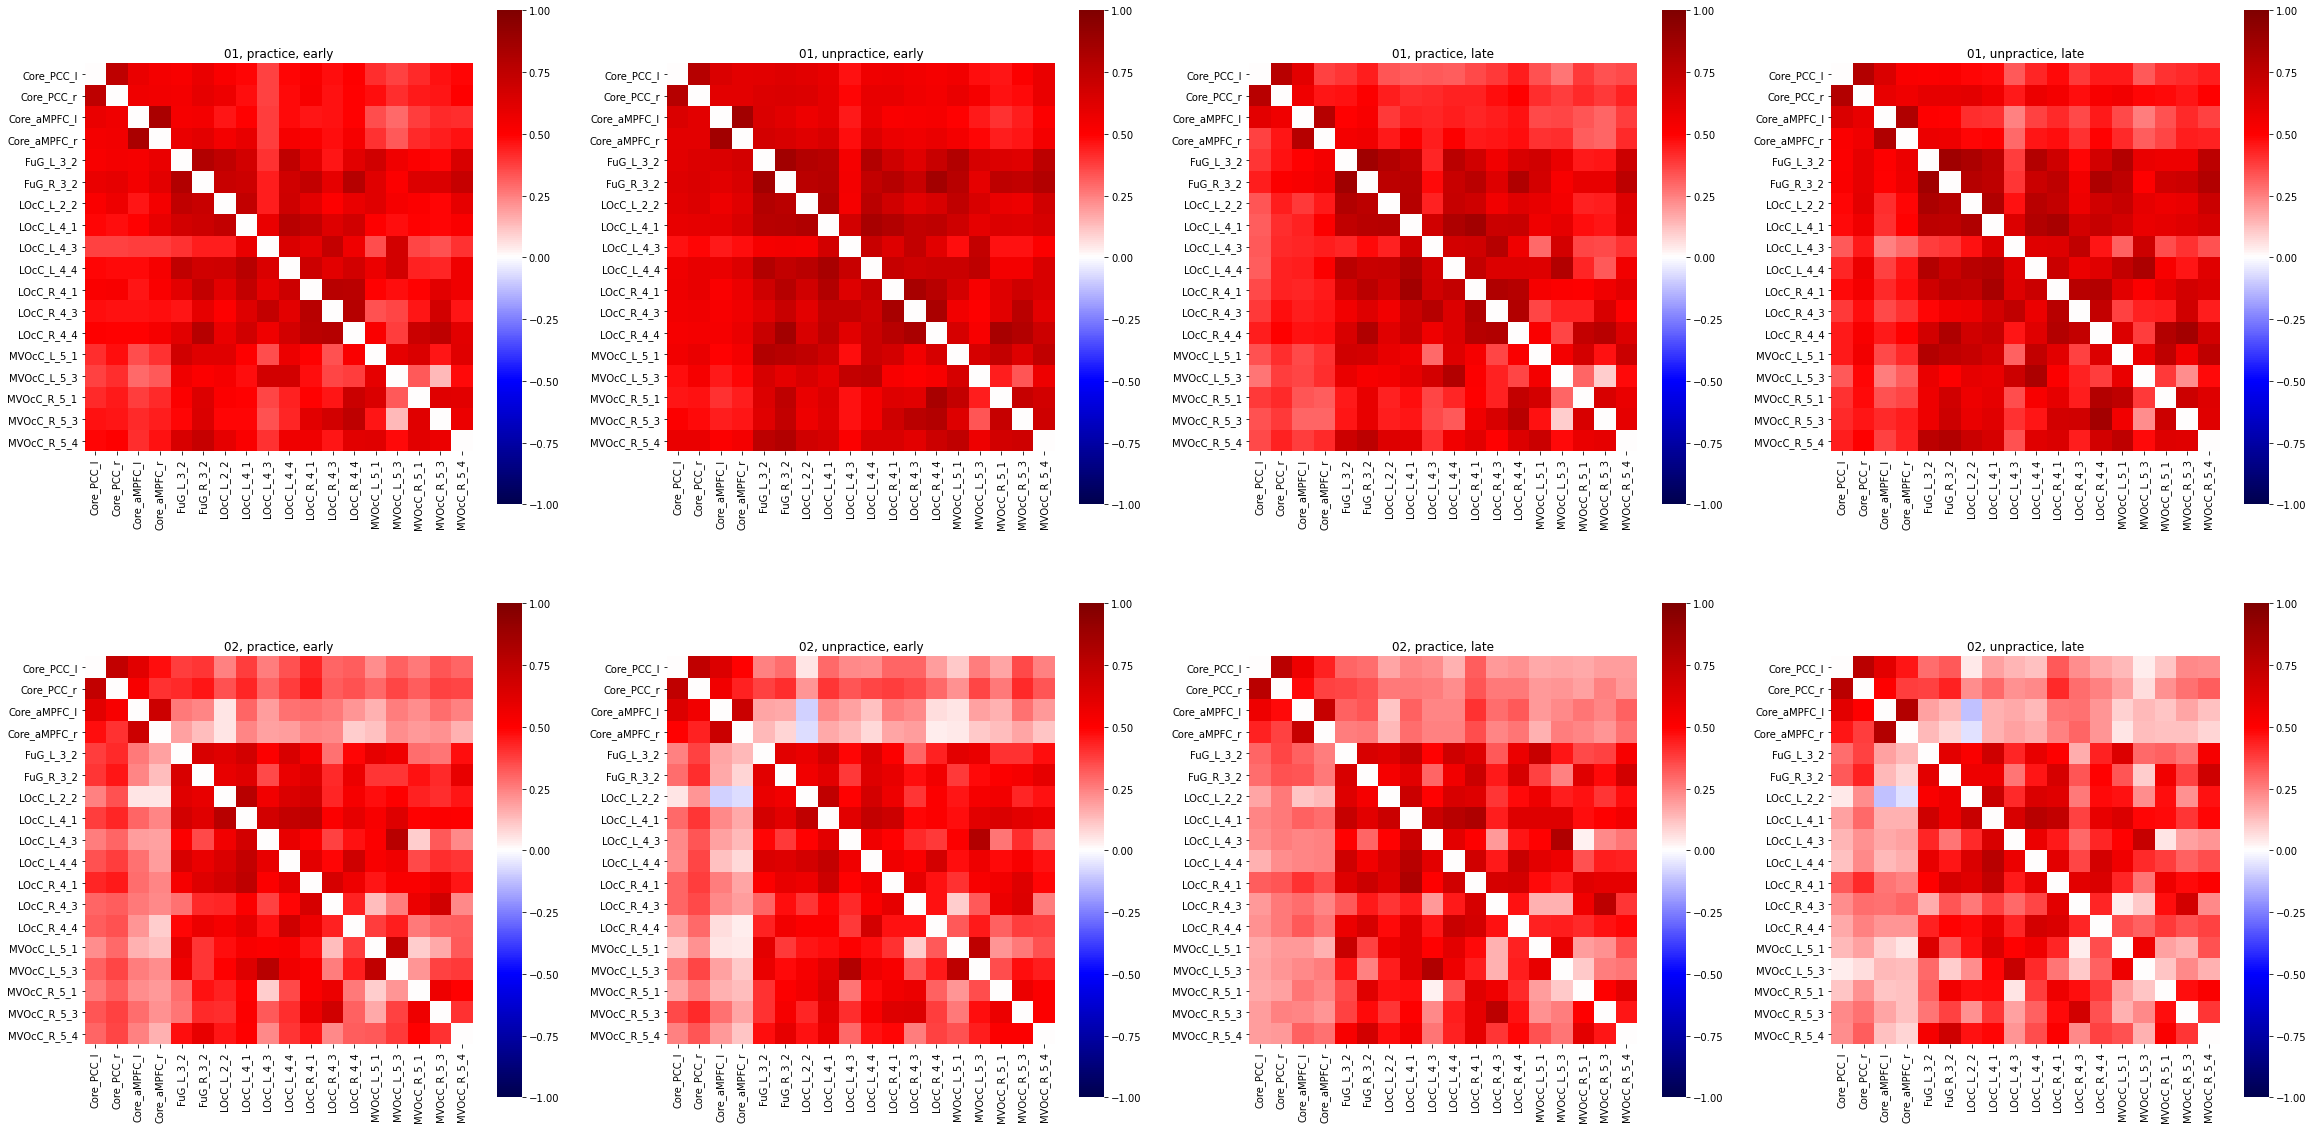

In [31]:
# subjs = GA.list_subj
subjs = ['01','02']
fig, axes = plt.subplots(nrows=len(subjs), ncols=4, figsize=(40, len(subjs)*10))
for i, subj in enumerate(subjs):
    ## initializing
    df_early = pd.DataFrame(np.zeros((len(sorted_rois),len(sorted_rois))), columns=sorted_rois, index=sorted_rois)
    df_late = df_early
    for j, mapping in enumerate(['practice', 'unpractice']):
        sum_corr = np.zeros(len(set(group)))
        for a, roiA in enumerate(sorted_rois):
            for roiB in sorted_rois[a+1:]:
                ## early
                df_early.loc[roiA][roiB] = df.loc[subj,'early',mapping,roiA,roiB]['Pearson_r']
                df_early.loc[roiB][roiA] = df_early.loc[roiA][roiB]
                ## late
                df_late.loc[roiA][roiB] = df.loc[subj,'late',mapping,roiA,roiB]['Pearson_r']
                df_late.loc[roiB][roiA] = df_late.loc[roiA][roiB]

        ## plot matrices
        ax = sns.heatmap(df_early
                         , square=True, cmap='seismic', cbar=True
#                          , robust=True
                         , vmin=-1., vmax=1.
                         , xticklabels=sorted_rois, yticklabels=sorted_rois, ax=axes[i][j])
        ax.set_title('%s, %s, %s'%(subj, mapping, 'early'))
        ## late
        ax = sns.heatmap(df_late
                         , square=True, cmap='seismic', cbar=True
#                          , robust=True
                         , vmin=-1., vmax=1.
                         , xticklabels=sorted_rois, yticklabels=sorted_rois, ax=axes[i][j+2])
        ax.set_title('%s, %s, %s'%(subj, mapping, 'late'))
# fig.savefig(fname=join(GA.dir_script,'matrices','%s_DMN_core-Yeo1_individual'%GA.today))

In [20]:
np.zeros(len(set(group)))

array([0., 0.])

In [32]:
for i, subj in enumerate(subjs):
    for j, mapping in enumerate(['practice', 'unpractice']):
        sum_corr = np.zeros(len(set(group)))
        for row, roiA in enumerate(sorted_rois):
            for col, roiB in enumerate(sorted_rois):
                
#         ## define I_(ki,kj) as 0. index 0, 3x3; index 1, 3x14; index 2, 14x14
#         ## normalization, D.S.Bassett et al. 2015

### *mean matrices (run once)

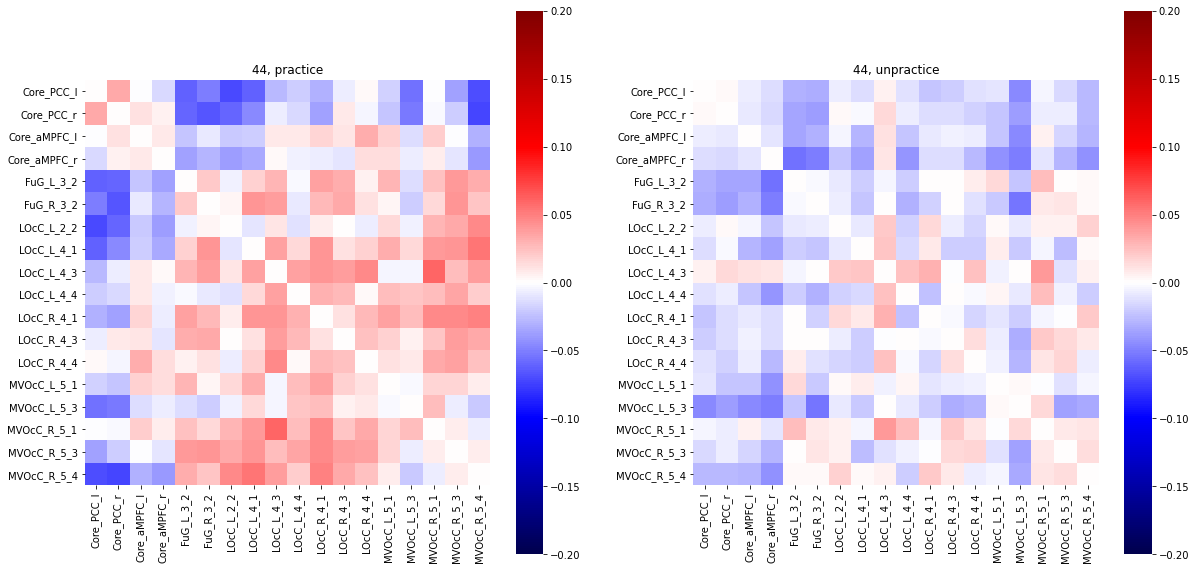

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
for i, mapping in enumerate(['practice', 'unpractice']):
    df_temp = pd.DataFrame(np.zeros((len(sorted_rois),len(sorted_rois))), columns=sorted_rois, index=sorted_rois)
    for a, roiA in enumerate(sorted_rois):
        for roiB in sorted_rois[a+1:]:
            temp = []
            for subj in GA.list_subj:
                temp.append(df.loc[subj,'late',mapping,roiA,roiB]['Pearson_r']-df.loc[subj,'early',mapping,roiA,roiB]['Pearson_r'])
            df_temp.loc[roiA][roiB] = np.mean(temp)
            df_temp.loc[roiB][roiA] = np.mean(temp)
    ax = sns.heatmap(df_temp
                     , square=True, cmap='seismic', cbar=True
#                      , robust=True
                     , vmin=-.2, vmax=.2
                     , xticklabels=sorted_rois, yticklabels=sorted_rois, ax=axes[i])
    ax.set_title('%s, %s'%(subj, mapping))
fig.savefig(fname=join(GA.dir_script,'matrices','%s_DMN_core-Yeo1_mean'%GA.today), dpi=300)

### unpractice

Text(0.5, 1.0, 'unpractice, GB-GA')

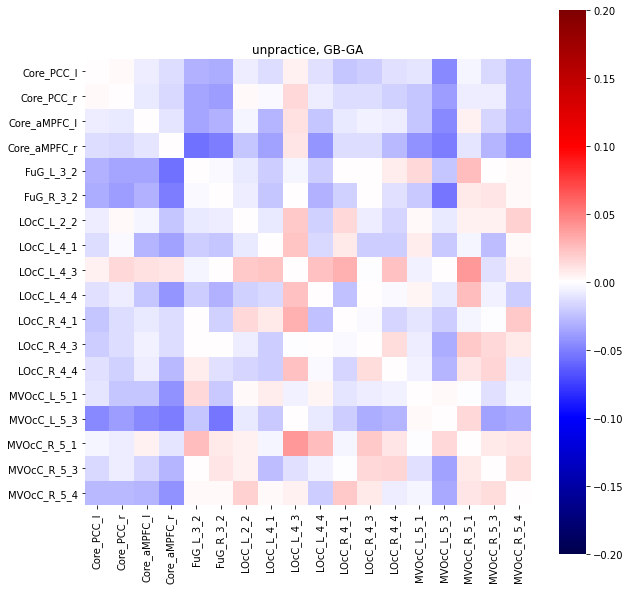

In [18]:
mapping = 'unpractice'
df_unprac = pd.DataFrame(np.zeros((len(sorted_rois),len(sorted_rois))), columns=sorted_rois, index=sorted_rois)
for a, roiA in enumerate(sorted_rois):
    for roiB in sorted_rois[a+1:]:
        temp = []
        for subj in GA.list_subj:
            temp.append(df.loc[subj,'late',mapping,roiA,roiB]['Pearson_r']-df.loc[subj,'early',mapping,roiA,roiB]['Pearson_r'])
        df_unprac.loc[roiA][roiB] = np.mean(temp)
        df_unprac.loc[roiB][roiA] = np.mean(temp)

plt.figure(figsize=(10,10))
ax = sns.heatmap(df_unprac
                 , square=True, cmap='seismic', cbar=True
#                      , robust=True
                 , vmin=-.2, vmax=.2
                 , xticklabels=sorted_rois, yticklabels=sorted_rois)
ax.set_title('%s, %s'%(mapping,'GB-GA'))

In [61]:
del_pearsonr = []
for subj in GA.list_subj:
    del_pearsonr.append(df.loc[subj,'late','practice',roiA,roiB]['Pearson_r'] - df.loc[subj,'early','practice',roiA,roiB]['Pearson_r'])

<AxesSubplot:title={'center':'r=0.0740 (p=0.698)'}, xlabel='Core_PCC_l-Core_PCC_r GB-GA', ylabel='Reward GB-GA'>

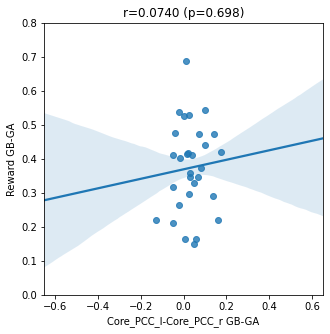

In [62]:
roiA = 'Core_PCC_l'
roiB = 'Core_PCC_r'
x_label = '%s-%s'%(roiA,roiB)
fig = plt.figure(figsize=(5, 5))
plt.xlim(-0.65, 0.65)
plt.ylim(-0., 0.8)
plt.ylabel('Reward GB-GA')
plt.xlabel('%s GB-GA'%x_label)
plt.title('r=%.4f (p=%.3f)' % (*scipy.stats.pearsonr(x=del_pearsonr, y=GA.del_RewardRate),))
sns.regplot(x=del_pearsonr, y=GA.del_RewardRate, ci=68, truncate=False)

### Yera's result

In [92]:
temp = pd.read_csv('/Users/clmn/Github/labs/GA/scripts/notebook/conn_comb.tsv', index_col=0)
temp

,subj,prac,behav,rcr_dmn,rcr_core,rcr_dmsub,rcr_core_dmsub,rcr_vis,rcr_mot,intg_vis_dmn,...,intg_vis_dmsub,intg_vis_core_dmsub,intg_mot_dmn,intg_mot_core,intg_mot_dmsub,intg_mot_core_dmsub,intg_task_dmn,intg_task_core,intg_task_dmsub,intg_task_core_dmsub
1,GA01,prac,0.417419,-0.103570,-0.118566,-0.062610,-0.106172,0.016287,-0.003815,-0.113725,...,-0.158438,-0.143824,-0.048679,-0.040207,-0.088327,-0.064329,-0.092550,-0.102630,-0.138719,-0.119447
2,GA02,prac,0.360081,0.013481,-0.028470,0.035389,-0.007518,0.051266,-0.100603,0.020214,...,0.033600,0.015019,0.117440,0.047972,0.116586,0.098419,0.049168,-0.006517,0.063294,0.042184
3,GA05,prac,0.346667,0.048872,0.088557,0.015633,0.039004,0.055081,0.061986,0.029226,...,0.043215,0.062298,0.068711,0.145580,0.042031,0.084334,0.056570,0.123231,0.053716,0.082903
4,GA07,prac,0.412720,-0.026085,0.042960,-0.049909,-0.018980,-0.023266,-0.181402,-0.176416,...,-0.162092,-0.209417,0.027160,0.014286,0.036141,0.031276,-0.108028,-0.170461,-0.094201,-0.130339
5,GA08,prac,0.212870,-0.171727,-0.063840,-0.094837,-0.145378,0.046188,-0.063819,-0.022113,...,-0.164946,-0.088188,0.201376,0.142111,0.096033,0.146802,0.046977,0.023879,-0.088342,-0.016496
6,GA11,prac,0.475243,-0.146506,-0.033110,-0.118157,-0.121286,-0.184554,-0.060405,-0.111644,...,-0.166317,-0.164692,-0.106477,-0.178146,-0.142495,-0.143151,-0.100386,-0.186364,-0.152574,-0.151531
7,GA12,prac,0.345544,-0.021644,0.053325,-0.040779,-0.053949,0.019848,0.040021,-0.024788,...,-0.004110,-0.018213,-0.181093,-0.143457,-0.186243,-0.165796,-0.064946,-0.098421,-0.057714,-0.059297
8,GA13,prac,0.329375,0.177759,-0.043590,0.217391,0.104026,0.185847,0.069396,0.075519,...,0.167532,0.144056,0.271868,0.192952,0.321320,0.296070,0.129210,0.105767,0.218252,0.192599
9,GA14,prac,0.545197,-0.050815,-0.050410,-0.046664,-0.068760,-0.007069,0.031257,-0.030788,...,-0.039221,-0.030967,-0.234723,-0.233454,-0.235090,-0.234472,-0.093133,-0.105166,-0.100384,-0.094693
10,GA15,prac,0.419329,-0.059917,0.041401,-0.047932,-0.030137,0.028375,-0.156555,-0.240224,...,-0.297786,-0.352405,-0.160415,-0.260338,-0.193630,-0.233928,-0.231385,-0.368954,-0.284595,-0.338021


In [67]:
with open('/Users/clmn/Github/labs/GA/scripts/notebook/MO_errts_AM1_corr_matrix_stage_prac_avg.pkl','rb') as fr:
    corr_matrix = pickle.load(file=fr)

In [79]:
corr_matrix.keys()

dict_keys([('early', 'prac'), ('early', 'unprac'), ('late', 'prac'), ('late', 'unprac')])

In [71]:
corr_matrix[('early','prac')].shape

(30, 52, 52)

In [21]:
## conn_visualize_bw.R
with open('/Users/clmn/Github/labs/GA/scripts/notebook/MO_errts_AM1_recruitment_prac_late-early.pkl','rb') as fr:
    recruitment = pickle.load(file=fr)

In [22]:
recruitment 

{('prac',
  ('dmn',
   'dmn')): array([-0.10356966,  0.01348072,  0.04887197, -0.02608503, -0.17172673,
        -0.14650591, -0.02164404,  0.17775926, -0.05081491, -0.05991694,
         0.10695166,  0.08394191,  0.04140708, -0.14577118,  0.04072315,
        -0.08084374, -0.04898123, -0.04145917, -0.01400077,  0.11543768,
        -0.00598698,  0.0625667 , -0.21861207, -0.12681002,  0.07977763,
        -0.05205754, -0.12210084, -0.0537106 , -0.13420753,  0.00063913]),
 ('unprac',
  ('dmn',
   'dmn')): array([-1.62141122e-01,  2.81677582e-02, -5.86568382e-02, -4.48499313e-02,
        -2.25349953e-01,  6.41524226e-02,  5.75340419e-02,  4.35941050e-02,
         5.74156108e-02, -7.30166153e-02, -1.14352680e-01,  5.65067208e-02,
         1.41184722e-01,  5.06033341e-03,  7.46578438e-02, -2.25393279e-02,
        -2.03647200e-01,  2.75149479e-02, -9.65544672e-02,  6.06302504e-02,
        -4.99495017e-02, -8.01128141e-02, -1.06877029e-01, -1.34228816e-01,
        -6.98105088e-05, -9.50698436e-03

In [78]:
list(recruitment.keys())

[('prac', ('dmn', 'dmn')),
 ('unprac', ('dmn', 'dmn')),
 ('prac', ('core', 'core')),
 ('unprac', ('core', 'core')),
 ('prac', ('dmsub', 'dmsub')),
 ('unprac', ('dmsub', 'dmsub')),
 ('prac', ('dmn_core_dmsub', 'dmn_core_dmsub')),
 ('unprac', ('dmn_core_dmsub', 'dmn_core_dmsub')),
 ('prac', ('visual', 'visual')),
 ('unprac', ('visual', 'visual')),
 ('prac', ('motor', 'motor')),
 ('unprac', ('motor', 'motor')),
 ('prac', ('task', 'task')),
 ('unprac', ('task', 'task')),
 ('prac', ('visual', 'dmn')),
 ('unprac', ('visual', 'dmn')),
 ('prac', ('visual', 'core')),
 ('unprac', ('visual', 'core')),
 ('prac', ('visual', 'dmsub')),
 ('unprac', ('visual', 'dmsub')),
 ('prac', ('visual', 'dmn_core_dmsub')),
 ('unprac', ('visual', 'dmn_core_dmsub')),
 ('prac', ('motor', 'dmn')),
 ('unprac', ('motor', 'dmn')),
 ('prac', ('motor', 'core')),
 ('unprac', ('motor', 'core')),
 ('prac', ('motor', 'dmsub')),
 ('unprac', ('motor', 'dmsub')),
 ('prac', ('motor', 'dmn_core_dmsub')),
 ('unprac', ('motor', 'dmn

# Searchlight